In [1]:
# Install and importing neccessary libraries
try:
    import polars as pl
except ImportError:
    !pip install polars
    import polars as pl
try:
    import folium
except ImportError:
    !pip install folium
    import folium

import time
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import branca.colormap as cm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [2]:
# Load Data
df = pl.read_parquet("./Data/Train_Rain_2years.parquet")
df

Searched Station,Date,Train Nr.,Train Type,Departing Station,Scheduled Departure Time,Arrival Station,Scheduled Arrival Time,Actual Arrival Time,Delay,Cancellation,On Time,Departure Hour,Arrival Hour,Day of Week,Month,Year,Station Latitude,Station Longitude,Matched Region,REGCODE,BL,Rain
str,date,str,str,str,datetime[μs],str,datetime[μs],datetime[μs],i64,i32,i32,i8,i8,i8,i8,i32,f64,f64,str,str,str,f64
"""Schwarzach_St._Veit""",2024-11-27,"""RJ 596""","""RJ""","""Salzburg Hbf""",2024-11-27 12:12:00,"""Schwarzach-St.Veit""",2024-11-27 13:09:00,2024-11-27 13:14:00,5,0,1,12,13,3,11,2024,47.318663,13.154399,"""Schwarzach""","""AT80235""","""Vorarlberg""",2.5
"""Feldkirch""",2023-04-04,"""RJX 897""","""RJX""","""Frankfurt(Main)Hbf""",2023-04-04 05:54:00,"""Feldkirch""",2023-04-04 11:12:00,2023-04-04 11:12:00,0,0,1,5,11,2,4,2023,47.240893,9.603943,"""Feldkirch""","""AT80404""","""Vorarlberg""",0.0
"""Golling_Abtenau""",2024-02-08,"""IC 793""","""IC""","""Klagenfurt Hbf""",2024-02-08 12:45:00,"""Golling-Abtenau""",2024-02-08 15:27:00,2024-02-08 15:28:00,1,0,1,12,15,4,2,2024,47.600786,13.164002,"""Abtenau""","""AT50201""","""Salzburg""",0.6
"""Bad_Gastein""",2023-03-28,"""RJ 696""","""RJ""","""Salzburg Hbf""",2023-03-28 17:16:00,"""Bad Hofgastein""",2023-03-28 18:34:00,2023-03-28 18:34:00,0,0,1,17,18,2,3,2023,47.196146,13.101515,"""Bad Hofgastein""","""AT50402""","""Salzburg""",2.4
"""Flughafen_Wien""",2023-07-12,"""RJX 863""","""RJX""","""Bregenz""",2023-07-12 06:39:00,"""Flughafen Wien""",2023-07-12 13:57:00,2023-07-12 14:09:00,12,0,0,6,13,3,7,2023,48.120223,16.564431,"""Schwechat""","""AT30740""","""Niederösterreich""",5.5
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Bruck/Mur""",2023-12-15,"""IC 733""","""IC""","""Wien Hbf""",2023-12-15 07:24:00,"""Bruck/Mur""",2023-12-15 09:13:00,2023-12-15 09:17:00,4,0,1,7,9,5,12,2023,47.413306,15.27922,"""Bruck an der Mur""","""AT62139""","""Steiermark""",0.1
"""Kufstein""",2023-11-07,"""RJX 766""","""RJX""","""Flughafen Wien""",2023-11-07 11:03:00,"""Kufstein""",2023-11-07 15:07:00,2023-11-07 15:25:00,18,0,0,11,15,2,11,2023,47.582139,12.165767,"""Kufstein""","""AT70513""","""Tirol""",5.8
"""Wien_Hbf""",2023-06-29,"""RJX 168""","""RJX""","""Flughafen Wien""",2023-06-29 15:03:00,"""Wien Hbf""",2023-06-29 15:18:00,2023-06-29 15:18:00,0,0,1,15,15,4,6,2023,48.185332,16.37865,"""Wien-Favoriten""","""AT91001""","""Wien""",0.0


### Rain Data on Map

In [3]:
avg_rain = df.group_by("REGCODE").agg([
    pl.col("Rain").mean().round(1).alias("Avg_Rain"),
    pl.len().alias("Reg_count"),
    pl.col("Arrival Station").first()
]).filter(pl.col("Reg_count") > 100)
coords = df.group_by("REGCODE").agg([
    pl.col("Station Latitude").first().alias("Lat"),
    pl.col("Station Longitude").first().alias("Lon")
])
rain_with_coords = avg_rain.join(
    coords,
    on = "REGCODE",
    how = "inner"
)

top_stations = df.group_by("Arrival Station").agg([
    pl.len().alias("Train_Count")
]).sort("Train_Count", descending = True)
station_locations = df.select(["Arrival Station", "Station Latitude", "Station Longitude"]).unique("Arrival Station")
top_stations_with_coords = top_stations.join(
    station_locations,
    on = "Arrival Station", 
    how = "left"
)

In [4]:
# Create map with center in Austria
m = folium.Map(location = [47.5, 13.3], zoom_start = 8, control_scale = True)

# Add colorscale for precipitation
colorscale = cm.LinearColormap(
    colors = ["white", "blue"],
    vmin = rain_with_coords["Avg_Rain"].min(),
    vmax = rain_with_coords["Avg_Rain"].max()
)
colorscale.add_to(m)

# Plot stations
for row in rain_with_coords.iter_rows(named = True):
    folium.CircleMarker(
        location = [row["Lat"], row["Lon"]],
        radius = 10,
        color = colorscale(row["Avg_Rain"]),
        fill = True,
        fill_color = colorscale(row["Avg_Rain"]),
        fill_opacity = 0.6,
        popup = (f"REGCODE: {row["REGCODE"]}<br>" 
                 f"Avg Rain: {row["Avg_Rain"]} mm"),
        tooltip = f"Click Station: {row["Arrival Station"]}"
    ).add_to(m)

# Include names for top 10 busiest stations
top_10 = top_stations_with_coords.sort("Train_Count", descending = True).head(10)
for row in top_10.iter_rows(named = True):
    folium.Marker(
        location = [row["Station Latitude"], row["Station Longitude"]],
        icon = folium.DivIcon(
            html = (
                f"<div style = 'font-size: 10pt; "
                f"transform: rotate(320deg); "
                f"font-weight:bold; "
                f"padding: 2px;'>"
                f"{row["Arrival Station"]}"
                f"</div>"
            )
        )
    ).add_to(m)

m

In [5]:
m.save("./Data/Weather/Maps/Rain_Station.html")

# Statistical Analysis

Checking for skewed data

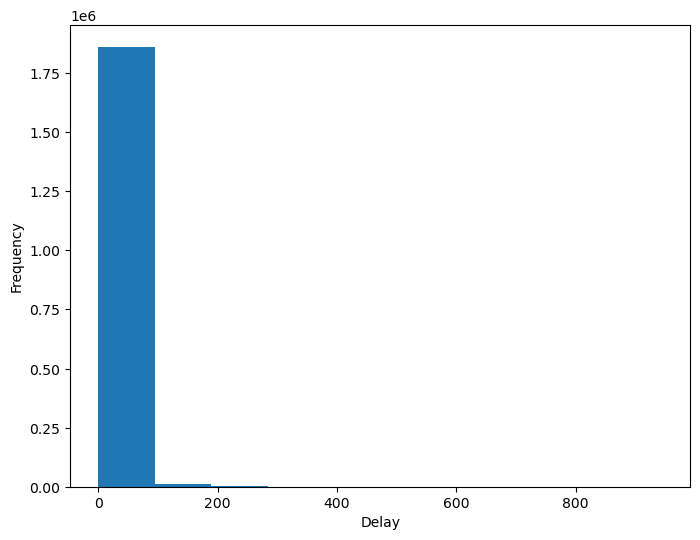

In [6]:
plt.figure(figsize = (8, 6))
plt.hist(df["Delay"])
plt.xlabel("Delay")
plt.ylabel("Frequency")
plt.show()

In [7]:
def categorize_rain(rain):
    if rain < 5:
        return 0 # No Rain
    elif rain < 15:
        return 1 # Light
    elif rain < 30:
        return 2 # Moderate
    else:
        return 3 # Heavy

df_trans = df.rename({"On Time": "On_Time"}).with_columns(
    np.log1p(pl.col("Delay")).alias("log_delay"),
    np.log1p(pl.col("Rain")).alias("log_rain"),
    pl.col("Rain").map_elements(categorize_rain, return_dtype = pl.Int64).alias("Rain_Category"),
    pl.when(pl.col("Delay") > df["Delay"].quantile(0.95))
    .then(df["Delay"].quantile(0.95))
    .otherwise(pl.col("Delay"))
    .alias("winsorized_delay")
)
df_cancel = df_trans.filter(pl.col("Cancellation") == 0)

In [8]:
# Checking the Fisher-Pearson coefficient of skewness
skew_delay = round(df_trans["Delay"].skew(), 2)
skew_delay_log = round(df_trans["log_delay"].skew(), 2)
skew_delay_win = round(df_trans["winsorized_delay"].skew(), 2)
skew_rain = round(df_trans["Rain"].skew(), 2)
skew_rain_log = round(df_trans["log_rain"].skew(), 2)
skew_rain_cat = round(df_trans["Rain_Category"].skew(), 2)

print(f"Delay Skewness: {skew_delay}")
print(f"Delay-Log-Transformed Skewness: {skew_delay_log}")
print(f"Delay-Winsor-Transformed Skewness: {skew_delay_win}")
print(f"Rain Skewness: {skew_rain}")
print(f"Rain-Log-Transformed Skewness: {skew_rain_log}")
print(f"Rain-Category-Transformed Skewness: {skew_rain_cat}")

Delay Skewness: 10.61
Delay-Log-Transformed Skewness: 1.14
Delay-Winsor-Transformed Skewness: 2.26
Rain Skewness: 5.47
Rain-Log-Transformed Skewness: 1.1
Rain-Category-Transformed Skewness: 2.21


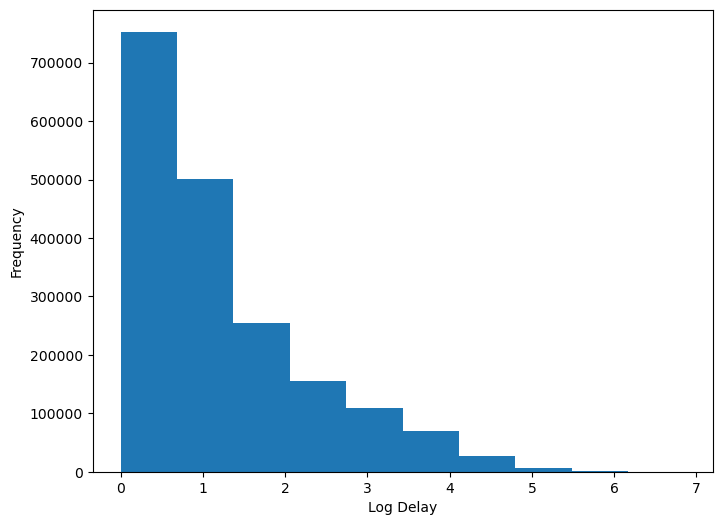

In [9]:
plt.figure(figsize = (8, 6))
plt.hist(df_cancel["log_delay"])
plt.xlabel("Log Delay")
plt.ylabel("Frequency")
plt.show()

### Exploratory Data & Correlation Analysis

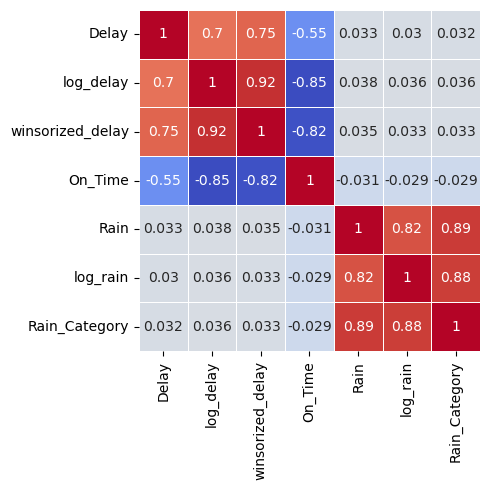

In [10]:
names = ["Delay","log_delay", "winsorized_delay", "On_Time", "Rain", "log_rain", "Rain_Category"]
corr_rain = df_cancel.select(names).corr()

plt.figure(figsize = (5, 5))
sns.heatmap(
    corr_rain,
    annot = True, 
    cmap = "coolwarm",  
    linewidths = 0.5,   
    cbar = False,
    xticklabels = names,
    yticklabels = names
)
plt.tight_layout()
plt.show()

### Regression Models

Linear & Logistic Regression 

In [11]:
# Statsmodels doesn't work with pandas
df_cancel_pd = df_cancel.to_pandas()
df_trans_pd = df_trans.to_pandas()

In [12]:
# Linear Regression
x_linear = df_cancel_pd[["Rain"]]
x_linear = sm.add_constant(x_linear) # include intercept with column of 1s
y_linear = df_cancel_pd["log_delay"]

# Fit OLS model
ols_model = sm.OLS(y_linear, x_linear)
ols_results = ols_model.fit()

print(ols_results.summary())

                            OLS Regression Results                            
Dep. Variable:              log_delay   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2658.
Date:                Wed, 02 Apr 2025   Prob (F-statistic):               0.00
Time:                        21:48:50   Log-Likelihood:            -2.9725e+06
No. Observations:             1875883   AIC:                         5.945e+06
Df Residuals:                 1875881   BIC:                         5.945e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0074      0.001   1067.865      0.0

In [13]:
# Logistic Regression
X_log = df_trans_pd[["Rain"]]
X_log = sm.add_constant(X_log) # include intercept with column of 1s
y_log = df_trans_pd["On_Time"]

# Fit logistic regression model
logit_model = sm.Logit(y_log, X_log)
logit_results = logit_model.fit()

print(logit_results.summary())

Optimization terminated successfully.
         Current function value: 0.540252
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                On_Time   No. Observations:              1905874
Model:                          Logit   Df Residuals:                  1905872
Method:                           MLE   Df Model:                            1
Date:                Wed, 02 Apr 2025   Pseudo R-squ.:                0.001177
Time:                        21:49:12   Log-Likelihood:            -1.0297e+06
converged:                       True   LL-Null:                   -1.0309e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2379      0.002    657.038      0.000       1.234       1.242
Rain          -0.0086      0.

Include geospatial distribution

In [14]:
# takes about 2h to load

start_time = time.time()

# Fit mixed linear model -> the groups are the different stations
mixed_model = smf.mixedlm("log_delay ~ Rain", 
                              df_cancel_pd, 
                              groups = df_cancel_pd["Arrival Station"],
                              re_formula = "~Rain")
mixed_model_results = mixed_model.fit()
print(mixed_model_results.summary())

# Get the random effects per station
random_effects = mixed_model_results.random_effects
random_effects_df = pd.DataFrame(random_effects).T.reset_index()
random_effects_df.columns = ["Arrival Station", "Intercept_Random", "Rain_Random"]

# Merge with coordinates for the map
df_stations = df_cancel_pd[["Arrival Station", "Station Latitude", "Station Longitude"]].drop_duplicates()
station_effects = pd.merge(
    df_stations,
    random_effects_df,
    on = "Arrival Station"
)

# Print highest effect on station for Austria
max_station = station_effects.loc[station_effects["Rain_Random"].idxmax()]
print("Station with the highest Rain_Random coefficient:")
print(max_station)

end_time = time.time()
total_time = (end_time - start_time) / 3600
print(f"Total run time: {total_time:.4f} hours")

/opt/conda/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/conda/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: log_delay    
No. Observations: 1875883 Method:             REML         
No. Groups:       289     Scale:              1.3591       
Min. group size:  1       Log-Likelihood:     -2950164.6410
Max. group size:  128921  Converged:          Yes          
Mean group size:  6490.9                                   
-----------------------------------------------------------
                  Coef. Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept         0.810    0.015 53.491 0.000  0.780  0.840
Rain              0.004    0.001  4.067 0.000  0.002  0.005
Group Var         0.038    0.002                           
Group x Rain Cov  0.001    0.000                           
Rain Var          0.000                                    

Station with the highest Rain_Random coefficient:
Arrival Station      Lend/Salzach
Station Latitude        47

In [15]:
# Visualize effects on a map
m = folium.Map(location = [47.5, 13.3], zoom_start = 8, control_scale = True)

# Add colorscale for precipitation
colorscale = cm.LinearColormap(
    colors = ["green", "gray", "red"],
    vmin = station_effects["Intercept_Random"].min(),
    vmax = station_effects["Intercept_Random"].max()
)
colorscale.add_to(m)

for index, row in station_effects.iterrows():
    folium.CircleMarker(
        location = [row["Station Latitude"], row["Station Longitude"]],
        radius = 9,
        color = colorscale(row["Intercept_Random"]),
        fill = True,
        fill_color = colorscale(row["Intercept_Random"]),
        fill_opacity = 0.6,
        popup = (f"Station: {row["Arrival Station"]}<br>"
                 f"Intercept Random: {row["Intercept_Random"]:.4f}<br>"
                 f"Rain Random: {row["Rain_Random"]:.4f}"),
        tooltip = f"Click: {row["Arrival Station"]}"
    ).add_to(m)

m

In [16]:
m.save("./Data/Weather/Maps/station_rain_map.html")

### Machine Learning

Takes about 13.6h to run  
##### Abbreviations
rf: Random Forest  
gb: Gradient Boosting  
mlp: Multi-Layer Perceptron  
  
reg: Regression  
class: Classification

In [17]:
# Split data into training and test
rain_reg_train, rain_reg_test, delay_reg_train, delay_reg_test = train_test_split(
    df_cancel_pd[["Rain"]],
    df_cancel_pd["Delay"],
    test_size = 0.2,
    random_state = 42
)
rain_class_train, rain_class_test, on_time_class_train, on_time_class_test = train_test_split(
    df_trans_pd[["Rain"]],
    df_trans_pd["On_Time"],
    test_size = 0.2,
    random_state = 42
)

In [18]:
# Defining best parameter options
# Regression
parameter_rf_reg = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}
parameter_gb_reg = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 7],
    "subsample": [0.8, 1.0]
}
parameter_mlp_reg = {
    "hidden_layer_sizes": [(100,), (50, 50), (100, 50)],
    "activation": ["relu", "tanh"],
    "alpha": [0.0001, 0.001, 0.01],
    "learning_rate_init": [0.001, 0.01],
    "max_iter": [100, 200, 500]
}

rf_reg = GridSearchCV(
    estimator = RandomForestRegressor(random_state = 42, n_jobs=-1),
    param_grid = parameter_rf_reg,
    scoring = "neg_mean_squared_error",
    n_jobs = -1
)
gb_reg = GridSearchCV(
    estimator = GradientBoostingRegressor(random_state = 42),
    param_grid = parameter_gb_reg,
    scoring = "neg_mean_squared_error",
    n_jobs = -1
)
mlp_reg = GridSearchCV(
    estimator = MLPRegressor(random_state = 42),
    param_grid = parameter_mlp_reg,
    scoring = "neg_mean_squared_error",
    n_jobs = -1
)

# Classification
parameter_rf_class = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "class_weight": [None, "balanced"]
}
parameter_gb_class = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 7],
    "subsample": [0.8, 1.0]
}
parameter_mlp_class = {
    "hidden_layer_sizes": [(100,), (50, 50)],
    "activation": ["relu", "tanh"],
    "alpha": [0.0001, 0.001, 0.01],
    "learning_rate_init": [0.001, 0.01],
    "max_iter": [100, 200, 500]
}

rf_class = GridSearchCV(
    estimator = RandomForestClassifier(random_state = 42),
    param_grid = parameter_rf_class,
    scoring = "accuracy",
    n_jobs = -1
)
gb_class = GridSearchCV(
    estimator = GradientBoostingClassifier(random_state = 42),
    param_grid = parameter_gb_class,
    scoring = "accuracy",
    n_jobs = -1
)
mlp_class = GridSearchCV(
    estimator = MLPClassifier(random_state = 42),
    param_grid = parameter_mlp_class,
    scoring = "accuracy",
    n_jobs = -1
)

In [19]:
# Run the models

start_time = time.time()

# Regression
rf_reg.fit(rain_reg_train, delay_reg_train)
gb_reg.fit(rain_reg_train, delay_reg_train)
mlp_reg.fit(rain_reg_train, delay_reg_train)

# Classification
rf_class.fit(rain_class_train, on_time_class_train)
gb_class.fit(rain_class_train, on_time_class_train)
mlp_class.fit(rain_class_train, on_time_class_train)

end_time = time.time()
total_time = (end_time - start_time) / 3600
print(f"Total training time: {total_time:.4f} hours")

Total training time: 13.6067 hours


In [20]:
# Parameter evaluation
best_rf_reg = rf_reg.best_estimator_
best_gb_reg = gb_reg.best_estimator_
best_mlp_reg = mlp_reg.best_estimator_
best_rf_class = rf_class.best_estimator_
best_gb_class = gb_class.best_estimator_
best_mlp_class = mlp_class.best_estimator_

In [27]:
print("======== Best Parameters ==========================================================================================================================")
print(f"Random Forest Regressor:     {rf_reg.best_params_}")
print(f"Gradient Boosting Regressor: {gb_reg.best_params_}")
print(f"MLP Regressor:               {mlp_reg.best_params_}")
print(f"Random Forest Classifier:    {rf_class.best_params_}")
print(f"Gradient Boosting Classifier:{gb_class.best_params_}")
print(f"MLP Classifier:              {mlp_class.best_params_}")
print("===================================================================================================================================================")

======== Best Parameters ==========================================================================================================================
Random Forest Regressor:     {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Gradient Boosting Regressor: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1.0}
MLP Regressor:               {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50), 'learning_rate_init': 0.001, 'max_iter': 100}
Random Forest Classifier:    {'class_weight': None, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Gradient Boosting Classifier:{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}
MLP Classifier:              {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.01, 'max_iter': 100}


In [22]:
# Model Results
# Regression
rf_reg_delay_prediction = best_rf_reg.predict(rain_reg_test)
rf_rmse = np.sqrt(mean_squared_error(delay_reg_test, rf_reg_delay_prediction))
rf_r2 = r2_score(delay_reg_test, rf_reg_delay_prediction)

gb_reg_delay_prediction = best_gb_reg.predict(rain_reg_test)
gb_rmse = np.sqrt(mean_squared_error(delay_reg_test, gb_reg_delay_prediction))
gb_r2 = r2_score(delay_reg_test, gb_reg_delay_prediction)

mlp_reg_delay_prediction = best_mlp_reg.predict(rain_reg_test)
mlp_rmse = np.sqrt(mean_squared_error(delay_reg_test, mlp_reg_delay_prediction))
mlp_r2 = r2_score(delay_reg_test, mlp_reg_delay_prediction)

# Classification
rf_class_on_time_prediction = best_rf_class.predict(rain_class_test)
rf_acc = accuracy_score(on_time_class_test, rf_class_on_time_prediction)
rf_f1 = f1_score(on_time_class_test, rf_class_on_time_prediction)
rf_auc = roc_auc_score(on_time_class_test, best_rf_class.predict_proba(rain_class_test)[:, 1])

gb_class_on_time_prediction = best_gb_class.predict(rain_class_test)
gb_acc = accuracy_score(on_time_class_test, gb_class_on_time_prediction)
gb_f1 = f1_score(on_time_class_test, gb_class_on_time_prediction)
gb_auc = roc_auc_score(on_time_class_test, best_gb_class.predict_proba(rain_class_test)[:, 1])

mlp_class_on_time_prediction = best_mlp_class.predict(rain_class_test)
mlp_acc = accuracy_score(on_time_class_test, mlp_class_on_time_prediction)
mlp_f1 = f1_score(on_time_class_test, mlp_class_on_time_prediction)
mlp_auc = roc_auc_score(on_time_class_test, best_mlp_class.predict_proba(rain_class_test)[:, 1])

In [24]:
print("======== Regression Metrics (Delay) ====================")
print(f"Random Forest Regressor:     RMSE = {rf_rmse:.4f}, R2 = {rf_r2:.4f}")
print(f"Gradient Boosting Regressor: RMSE = {gb_rmse:.4f}, R2 = {gb_r2:.4f}")
print(f"MLP Regressor:               RMSE = {mlp_rmse:.4f}, R2 = {mlp_r2:.4f}")
print("========================================================")

print("\n======== Classification Metrics (On Time) ==========================================")
print(f"Random Forest Classifier:     Accuracy = {rf_acc:.4f}, F1 Score = {rf_f1:.4f}, ROC-AUC = {rf_auc:.4f}")
print(f"Gradient Boosting Classifier: Accuracy = {gb_acc:.4f}, F1 Score = {gb_f1:.4f}, ROC-AUC = {gb_auc:.4f}")
print(f"MLP Classifier:               Accuracy = {mlp_acc:.4f}, F1 Score = {mlp_f1:.4f}, ROC-AUC = {mlp_auc:.4f}")
print("====================================================================================")

======== Regression Metrics (Delay) ====================
Random Forest Regressor:     RMSE = 18.2273, R2 = 0.0020
Gradient Boosting Regressor: RMSE = 18.2263, R2 = 0.0021
MLP Regressor:               RMSE = 18.2339, R2 = 0.0013

======== Classification Metrics (On Time) ==========================================
Random Forest Classifier:     Accuracy = 0.7683, F1 Score = 0.8688, ROC-AUC = 0.5232
Gradient Boosting Classifier: Accuracy = 0.7682, F1 Score = 0.8689, ROC-AUC = 0.5228
MLP Classifier:               Accuracy = 0.7681, F1 Score = 0.8689, ROC-AUC = 0.5185
